# Multimodal IMDB Analysis with Keras

## Introduction

We will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure

This is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import LearningRateScheduler

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Processing

Warning: running the following cell can take some time.


In [32]:
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Mini_Projects/Multimodel_IMDB_Analysis/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/

mkdir: cannot create directory ‘/tmp/Multimodal_IMDB_dataset’: File exists
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7897)   


In [33]:
csv_loc = "/content/drive/MyDrive/Mini_Projects/Multimodel_IMDB_Analysis/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [34]:
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [35]:
def img_process(image, label):

    #Convert image to float32
    image = tf.image.convert_image_dtype(image, tf.float32)
    #Resize image to 64x64
    image = tf.image.resize(image, [64, 64])

    return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [36]:
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train)) \
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE) \
    .cache() \
    .batch(64) \
    .prefetch(tf.data.AUTOTUNE)

posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test)) \
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE) \
    .cache() \
    .batch(64) \
    .prefetch(tf.data.AUTOTUNE)

### 1.b. Natural Language processing of the overviews

In [37]:
# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [38]:
### Construct the training and validation datasets. Use a batch size of 64.

overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train)).batch(64).prefetch(tf.data.AUTOTUNE)

overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test)).batch(64).prefetch(tf.data.AUTOTUNE)

* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [39]:
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000


encoder = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int')

encoder.adapt(overviews_train_ds.map(lambda text, label: text))

* Print the first 200 words of the vocabulary you obtained.

In [40]:
### Print the first 200 words of the vocabulary you obtained.

print(encoder.get_vocabulary()[:200])

['', '[UNK]', np.str_('a'), np.str_('the'), np.str_('to'), np.str_('of'), np.str_('and'), np.str_('in'), np.str_('his'), np.str_('is'), np.str_('an'), np.str_('with'), np.str_('her'), np.str_('for'), np.str_('on'), np.str_('he'), np.str_('their'), np.str_('who'), np.str_('by'), np.str_('from'), np.str_('when'), np.str_('as'), np.str_('that'), np.str_('after'), np.str_('young'), np.str_('life'), np.str_('man'), np.str_('they'), np.str_('him'), np.str_('at'), np.str_('are'), np.str_('two'), np.str_('new'), np.str_('but'), np.str_('into'), np.str_('has'), np.str_('up'), np.str_('she'), np.str_('family'), np.str_('woman'), np.str_('out'), np.str_('love'), np.str_('one'), np.str_('must'), np.str_('find'), np.str_('be'), np.str_('friends'), np.str_('it'), np.str_('finds'), np.str_('story'), np.str_('world'), np.str_('school'), np.str_('them'), np.str_('where'), np.str_('about'), np.str_('have'), np.str_('while'), np.str_('group'), np.str_('home'), np.str_('father'), np.str_('years'), np.str_

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.

In [41]:
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():
    input_layer = Input(shape=(64, 64, 3), name="Input")  # First line!

    x = Conv2D(16, (3, 3), activation='relu', padding='same', name="Conv0")(input_layer)
    x = Dropout(0.2, name="Drop1")(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv1")(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv2")(x)
    x = Dropout(0.2, name="Drop2")(x)
    x = MaxPooling2D(pool_size=(2, 2), name="Pool1")(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv3")(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv4")(x)
    x = Dropout(0.2, name="Drop3")(x)
    x = MaxPooling2D(pool_size=(2, 2), name="Pool2")(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv5")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv6")(x)
    x = Dropout(0.2, name="Drop4")(x)
    x = MaxPooling2D(pool_size=(2, 2), name="Pool3")(x)

    x = Flatten(name="Flat")(x)
    x = Dense(1024, activation='relu', name="FC1")(x)
    x = Dropout(0.5, name="Drop5")(x)
    x = Dense(1024, activation='relu', name="FC2")(x)
    x = Dropout(0.5, name="Drop6")(x)
    output_layer = Dense(25, activation='sigmoid', name="Output")(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

cnn_model = build_cnn_model()

* Print the model summary and confirm it has the same architecture as the one provided.

In [42]:
### Print the model summary and confirm it has the same architecture as the one
### provided.

cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv0 (Conv2D)                  │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop2 (Dropout)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop3 (Dropout)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop4 (Dropout)                 │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (Flatten)                  │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop5 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop6 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 25)             │        25,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,756,057 (37.22 MB)

 Trainable params: 9,756,057 (37.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [43]:
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

cnn_model.compile(
    #Complete here
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall']
    )

### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [44]:
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

embedder = tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=256, mask_zero=True)

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [45]:
### Build a keras sequential model, with the layers provided above.

lstm_model = tf.keras.Sequential([
    encoder,
    embedder,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(25, activation='sigmoid')
])

lstm_model.build((None,))

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [46]:
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 512)      │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [47]:
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

lstm_model.compile(
    #Complete here
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[Precision(), Recall()]
    )

# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [48]:
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn_callback = ModelCheckpoint(
    filepath=checkpoint_cnn_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True
)

checkpoint_lstm_callback = ModelCheckpoint(
    filepath=checkpoint_lstm_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True
)

* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [49]:
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)


### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [50]:
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    #Complete here
    posters_train_ds,
    validation_data=posters_valid_ds,
    epochs=40,
    callbacks=[checkpoint_cnn_callback, lr_callback]
    )
# Run this to see the correct names for your metrics
print(cnn_history.history.keys())

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - Precision: 0.2964 - Recall: 0.2762 - loss: 0.3933 - val_Precision: 0.5431 - val_Recall: 0.2255 - val_loss: 0.3586 - learning_rate: 1.0000e-04
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - Precision: 0.4943 - Recall: 0.2220 - loss: 0.2544 - val_Precision: 0.5748 - val_Recall: 0.3204 - val_loss: 0.3175 - learning_rate: 1.0000e-04
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - Precision: 0.5475 - Recall: 0.2410 - loss: 0.2418 - val_Precision: 0.5762 - val_Recall: 0.3116 - val_loss: 0.3048 - learning_rate: 1.0000e-04
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - Precision: 0.5554 - Recall: 0.2484 - loss: 0.2399 - val_Precision: 0.5773 - val_Recall: 0.3017 - val_loss: 0.2999 - learning_rate: 1.0000e-04
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - Precision: 0.5586 - Recall: 0.2542 - loss: 0.2364 - val_Precision: 0.5775 - val_Recall: 0.3020 - val_loss: 0.2885 - learning_rate: 1.0000e-04
Epoch 6/40
80/80 ━━━━━━━━

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [51]:
# Train the model for 20 epochs.
lstm_history = lstm_model.fit(
                    #Complete here
                    overviews_train_ds,
                    validation_data=overviews_valid_ds,
                    epochs=20,
                    callbacks=[checkpoint_lstm_callback, lr_callback]
                    )

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 0.6570 - precision_2: 0.1189 - recall_2: 0.3975 - val_loss: 0.3255 - val_precision_2: 0.5431 - val_recall_2: 0.2255 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - loss: 0.4422 - precision_2: 0.1879 - recall_2: 0.2999 - val_loss: 0.2776 - val_precision_2: 0.5431 - val_recall_2: 0.2255 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.3927 - precision_2: 0.2307 - recall_2: 0.2817 - val_loss: 0.2613 - val_precision_2: 0.5431 - val_recall_2: 0.2255 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 0.3616 - precision_2: 0.2629 - recall_2: 0.2588 - val_loss: 0.2533 - val_precision_2: 0.5431 - val_recall_2: 0.2255 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.3429 - precision_2: 0.2962 - recall_2: 0.2547 - val_loss: 0.2493 - val_precision_2: 0.5431 - val_recall_2: 0.2255 - learning_ra

# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

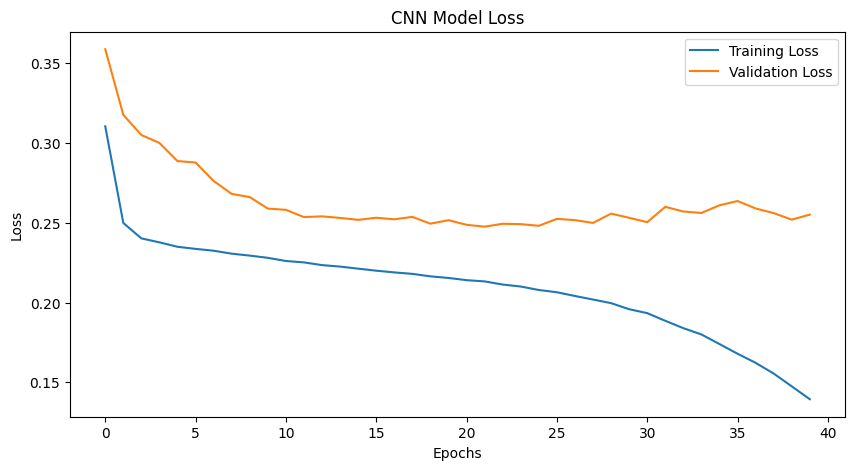

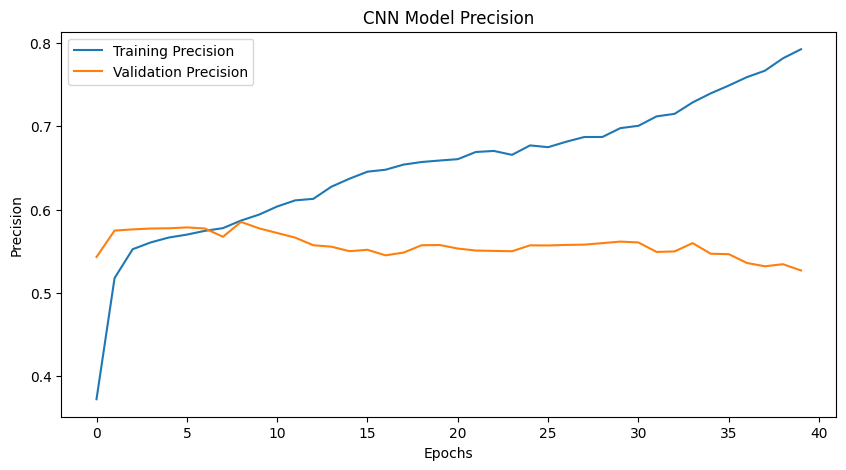

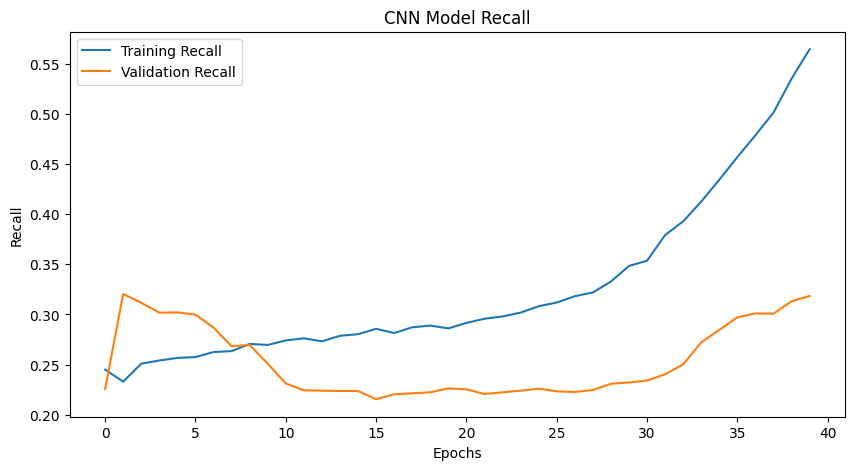

In [54]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Precision (with correct capitalization)
plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['Precision'], label='Training Precision')
plt.plot(cnn_history.history['val_Precision'], label='Validation Precision')
plt.title('CNN Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall (with correct capitalization)
plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['Recall'], label='Training Recall')
plt.plot(cnn_history.history['val_Recall'], label='Validation Recall')
plt.title('CNN Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['precision_1'], label='Training Precision')
plt.plot(lstm_history.history['val_precision_1'], label='Validation Precision')
plt.title('LSTM Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['recall_1'], label='Training Recall')
plt.plot(lstm_history.history['val_recall_1'], label='Validation Recall')
plt.title('LSTM Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


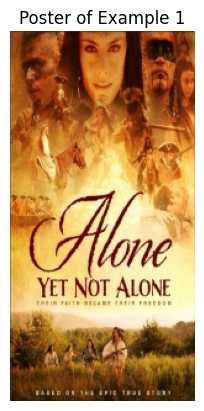

Overview Text 1: The year is 1755, and the English colonies are being ravaged by the atrocities of war. Opposing European powers have clashed over the fertile Ohio valley, and entire families are devastated...
Actual Genres: ['History']
Top 3 CNN Predicted Genres: ['Drama', 'Romance', 'Comedy']
Top 3 LSTM Predicted Genres: ['Drama', 'Comedy', 'Action']
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


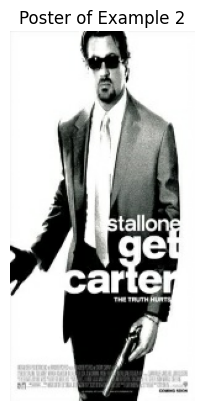

Overview Text 2: A Las Vegas mob enforcer travels back to his hometown to investigate his brother's mysterious death.
Actual Genres: ['Action', 'Crime', 'Drama']
Top 3 CNN Predicted Genres: ['Comedy', 'Drama', 'Romance']
Top 3 LSTM Predicted Genres: ['Drama', 'Comedy', 'Action']
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


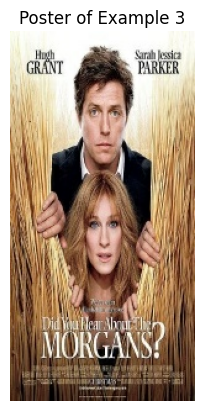

Overview Text 3: In New York City, an estranged couple who witness a murder are relocated to small town Wyoming as part of the Witness Protection Program.
Actual Genres: ['Comedy', 'Drama', 'Romance']
Top 3 CNN Predicted Genres: ['Drama', 'Romance', 'Comedy']
Top 3 LSTM Predicted Genres: ['Drama', 'Comedy', 'Action']
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


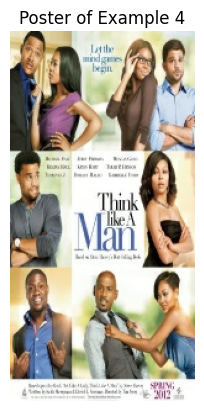

Overview Text 4: Four friends conspire to turn the tables on their women when they discover the ladies have been using Steve Harvey's relationship advice against them.
Actual Genres: ['Comedy', 'Romance']
Top 3 CNN Predicted Genres: ['Comedy', 'Drama', 'Romance']
Top 3 LSTM Predicted Genres: ['Drama', 'Comedy', 'Romance']
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


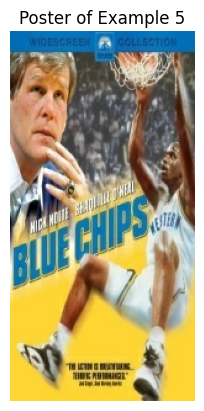

Overview Text 5: A college basketball coach is forced to break the rules in order to get the players he needs to stay competitive.
Actual Genres: ['Drama', 'Sport']
Top 3 CNN Predicted Genres: ['Comedy', 'Drama', 'Romance']
Top 3 LSTM Predicted Genres: ['Drama', 'Comedy', 'Action']
--------------------------------------------------------------------------------


In [55]:
# Load the best model weights
cnn_model.load_weights('/content/checkpoint_cnn.weights.h5')
lstm_model.load_weights('/content/checkpoint_lstm.weights.h5')

# Pick random samples safely
import random
sample_indices = random.sample(range(len(img_locs_test[0])), min(5, len(img_locs_test[0])))

# Loop through each sample
for i, idx in enumerate(sample_indices):
    # Poster prediction
    img_path = img_locs_test[0][idx]
    img = tf.io.decode_jpeg(tf.io.read_file(img_path))
    resized_img = tf.image.resize(img, (64, 64))
    resized_img = tf.expand_dims(resized_img, axis=0)
    cnn_pred = cnn_model.predict(resized_img)

    # Overview prediction
    overview_text = overviews_test[idx]    # just get the overview
    lstm_pred = lstm_model.predict(tf.constant([overview_text]))  # directly pass string

    # Display Poster
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Poster of Example {i+1}")
    plt.show()

    # Print overview text
    print(f"Overview Text {i+1}:", overview_text)

    # Ground truth genres
    actual_genres = np.where(labels_test[idx] == 1)[0]
    print("Actual Genres:", [genres[i] for i in actual_genres])

    # Top 3 CNN predictions
    top_cnn = np.argsort(cnn_pred[0])[-3:][::-1]
    print("Top 3 CNN Predicted Genres:", [genres[i] for i in top_cnn])

    # Top 3 LSTM predictions
    top_lstm = np.argsort(lstm_pred[0])[-3:][::-1]
    print("Top 3 LSTM Predicted Genres:", [genres[i] for i in top_lstm])

    print("-" * 80)
